In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Loading the Fine damage dataset

In [3]:
class CustomSemanticSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None, target_size=(512, 512)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform  # Separate transform for masks
        self.target_size = target_size
        self.num_classes = 7

        # Include only image files
        self.image_filenames = [f for f in sorted(os.listdir(image_dir))
                                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]


    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace('.jpg', '.png'))

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        # Resize the image and mask
        image = image.resize(self.target_size, Image.BILINEAR)
        mask = mask.resize(self.target_size, Image.NEAREST)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            mask = self.target_transform(mask)

        # Convert mask to numpy array for processing
        mask = np.array(mask)

        # Create one-hot encoding for mask
        mask_one_hot = torch.zeros((self.num_classes, *self.target_size), dtype=torch.float32)
        for class_idx in range(self.num_classes):
            mask_one_hot[class_idx] = torch.from_numpy(mask == class_idx).float()

        return image, mask_one_hot


## Load data

## Splitting the data into train and test - Fine

In [4]:
train_image_dir = r"/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/Damage dataset/imageDamage/FineDamage_split/train/images"
test_image_dir = r"/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/Damage dataset/imageDamage/FineDamage_split/test/images"
train_mask_dir = r"/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/Damage dataset/imageDamage/FineDamage_split/train/masks"
test_mask_dir = r"/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/Damage dataset/imageDamage/FineDamage_split/test/masks"

## Train the model

In [9]:
# Define hyperparameters
batch_size = 4
learning_rate = 0.001
num_epochs = 100
num_classes = 7

# Define your custom dataset and data loaders

train_dataset = CustomSemanticSegmentationDataset(train_image_dir, train_mask_dir, transform=transforms.Compose([transforms.ToTensor()]), target_size=(512,512))
test_dataset = CustomSemanticSegmentationDataset(test_image_dir, test_mask_dir, transform=transforms.Compose([transforms.ToTensor()]), target_size=(512,512))

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Load a pre-trained DeepLabV3 model
weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = models.segmentation.deeplabv3_resnet50(weights=weights)

# Modify the classifier for 8 classes
model.classifier[4] = nn.Conv2d(model.classifier[4].in_channels, num_classes, kernel_size=1)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    num_batches = 0

    for inputs, masks in train_loader:
        inputs, masks = inputs.to(device), masks.to(device)
        masks = masks.squeeze(1)  # Remove channel dimension if present
        optimizer.zero_grad()
        outputs = model(inputs)['out']
        loss = criterion(outputs, masks)  # Ensure masks are long type
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")

# Save the fine-tuned model
torch.save(model.state_dict(), 'fine_tuned_segmentation_model_trainimages_100epochs.pth')


Epoch 1/100, Loss: 0.1783
Epoch 2/100, Loss: 0.0602
Epoch 3/100, Loss: 0.0576
Epoch 4/100, Loss: 0.0564
Epoch 5/100, Loss: 0.0539
Epoch 6/100, Loss: 0.0529
Epoch 7/100, Loss: 0.0512
Epoch 8/100, Loss: 0.0505
Epoch 9/100, Loss: 0.0501
Epoch 10/100, Loss: 0.0495
Epoch 11/100, Loss: 0.0477
Epoch 12/100, Loss: 0.0487
Epoch 13/100, Loss: 0.0475
Epoch 14/100, Loss: 0.0487
Epoch 15/100, Loss: 0.0465
Epoch 16/100, Loss: 0.0478
Epoch 17/100, Loss: 0.0463
Epoch 18/100, Loss: 0.0444
Epoch 19/100, Loss: 0.0444
Epoch 20/100, Loss: 0.0455
Epoch 21/100, Loss: 0.0449
Epoch 22/100, Loss: 0.0448
Epoch 23/100, Loss: 0.0422
Epoch 24/100, Loss: 0.0414
Epoch 25/100, Loss: 0.0411
Epoch 26/100, Loss: 0.0404
Epoch 27/100, Loss: 0.0428
Epoch 28/100, Loss: 0.0509
Epoch 29/100, Loss: 0.0447
Epoch 30/100, Loss: 0.0472
Epoch 31/100, Loss: 0.0429
Epoch 32/100, Loss: 0.0424
Epoch 33/100, Loss: 0.0424
Epoch 34/100, Loss: 0.0405
Epoch 35/100, Loss: 0.0385
Epoch 36/100, Loss: 0.0381
Epoch 37/100, Loss: 0.0368
Epoch 38/1

## Color map function

In [6]:
# Define your color map
color_map = {
    0: [0, 0, 0],       # No - black
    1: [255, 0, 0],     # Scratches - red
    2: [0, 255, 0],     # Grooves/Joints - green
    3: [255, 255, 255], # Cables - white
    4: [211, 211, 211], # Filled Cracks - lightgrey
    5: [255, 0, 0],     # Cracks - red
    6: [255, 165, 0]    # Exposed Rebar - orange
}
# Function to apply color mapping to an image
def apply_color_map(image, color_map):
    height, width = image.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for key, color in color_map.items():
        indices = image == key
        color_mask[indices] = color
    return color_mask

## Inference Model trained on train images (fine) for 100 epochs 

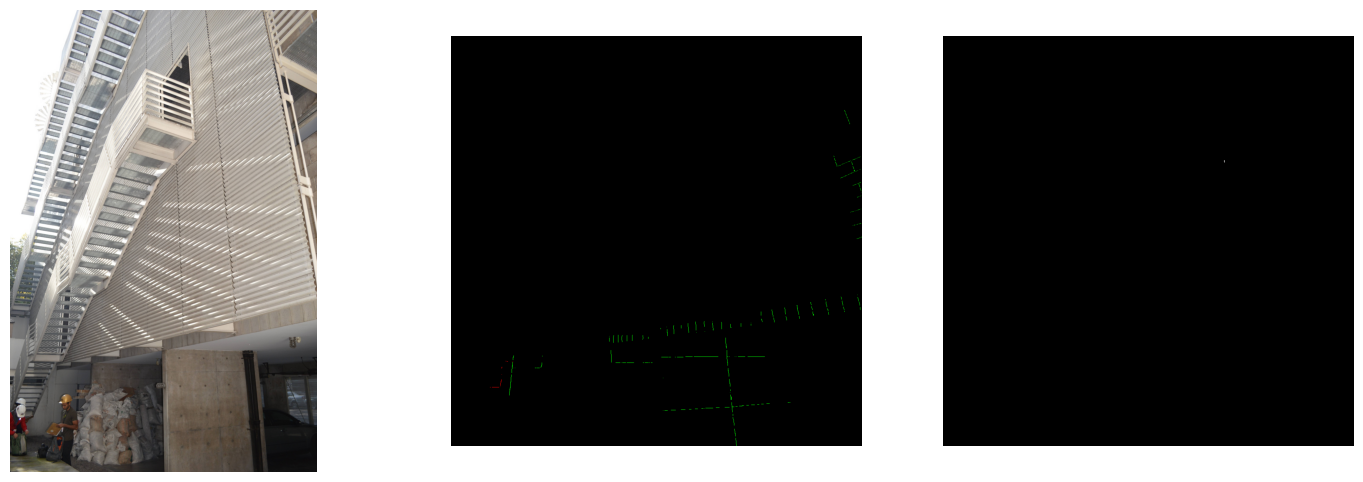

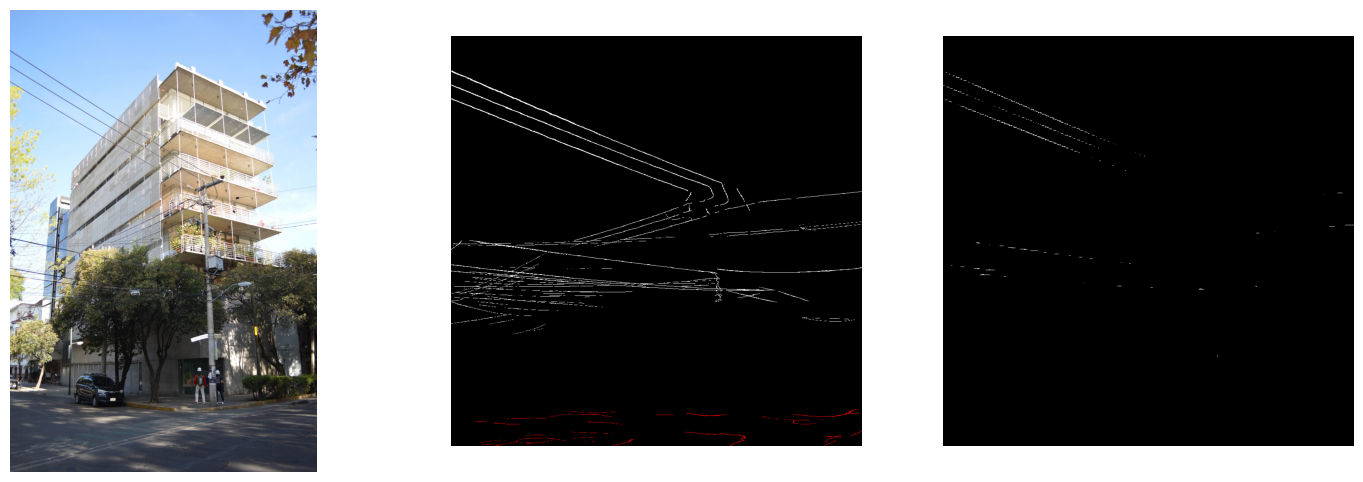

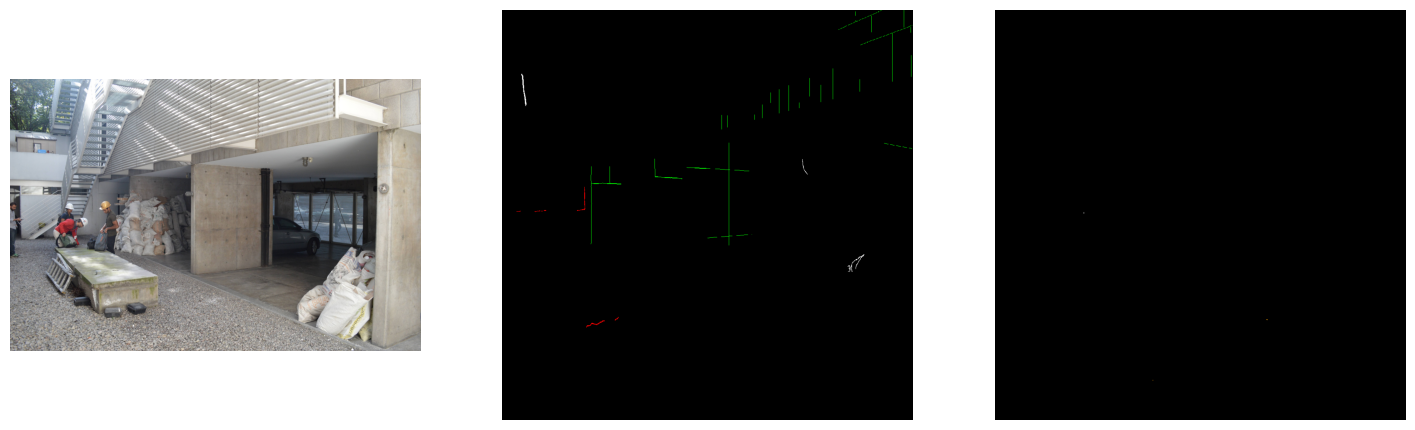

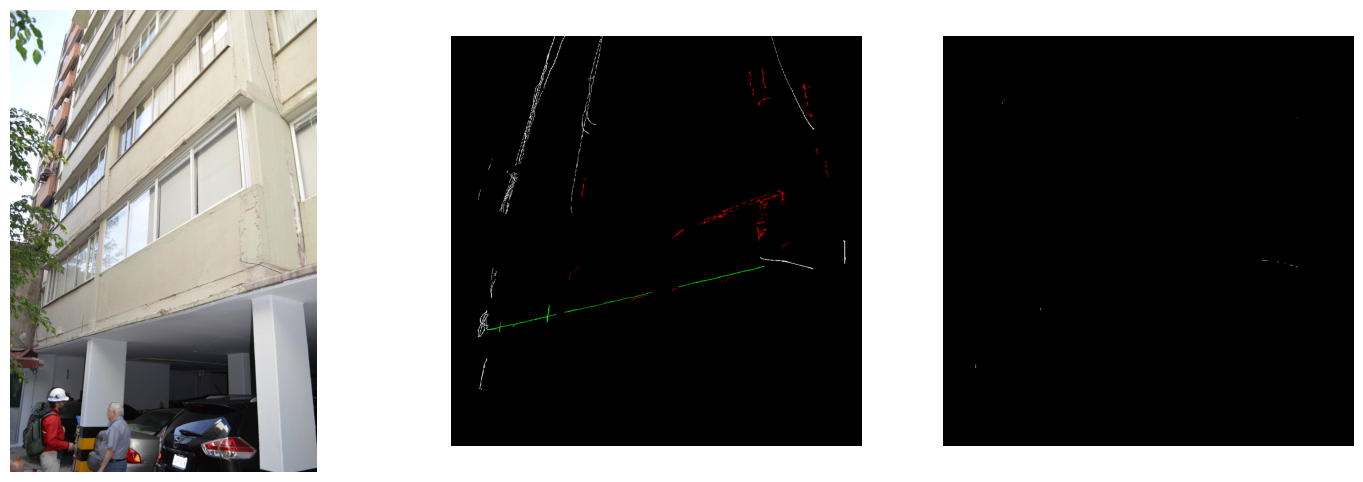

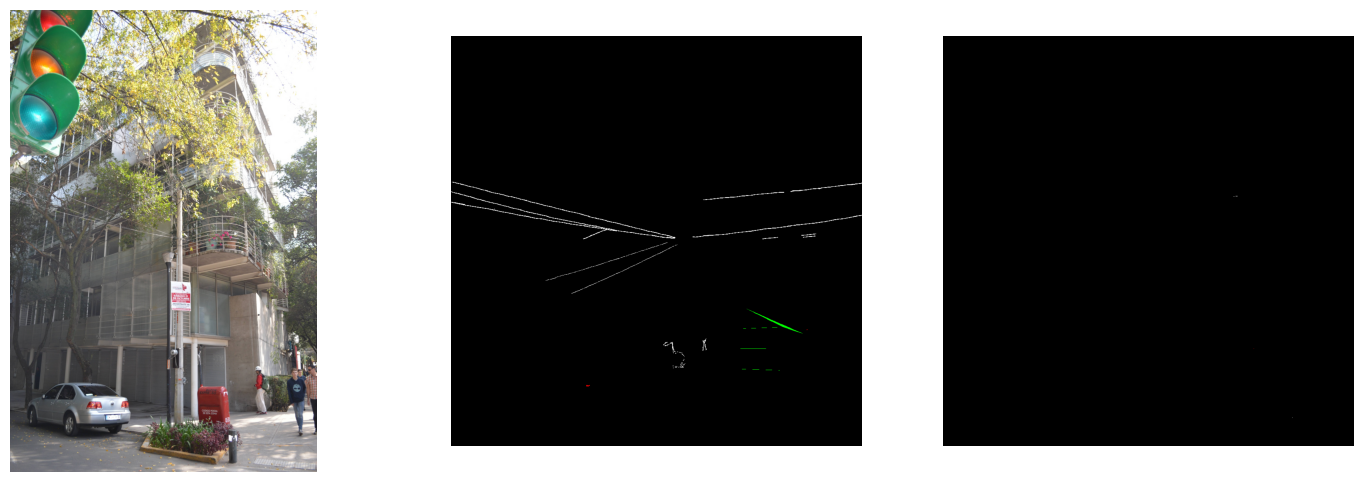

In [8]:

# Load the fine-tuned model
model = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
num_classes = 7
model.classifier[4] = nn.Conv2d(model.classifier[4].in_channels, num_classes, kernel_size=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Load the saved state_dict
model.load_state_dict(torch.load('/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/fine_tuned_segmentation_model_FineiDamage 101.pth', map_location='cpu'))
model.eval()

# List of image and ground truth mask paths
image_and_mask_paths = [
    ('/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/Damage dataset/imageDamage/FineDamage_split/test/images/01_RCB0017_F03_DSC_0084007.jpg','/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/Damage dataset/imageDamage/FineDamage_split/test/masks/01_RCB0017_F03_DSC_0084007.png'),
    ('/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/Damage dataset/imageDamage/FineDamage_split/train/images/01_RCB0017_F01_DSC_0076000.jpg','/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/Damage dataset/imageDamage/FineDamage_split/train/masks/01_RCB0017_F01_DSC_0076000.png'),
    ('/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/Damage dataset/imageDamage/FineDamage_split/train/images/01_RCB0017_F03_DSC_0081005.jpg','/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/Damage dataset/imageDamage/FineDamage_split/train/masks/01_RCB0017_F03_DSC_0081005.png'),
    ('Damage dataset/imageDamage/FineDamage_split/train/images/01_RCB0018_F12_DSC_0133002.jpg','/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/Damage dataset/imageDamage/FineDamage_split/train/masks/01_RCB0018_F12_DSC_0133002.png'),
    ('Damage dataset/imageDamage/FineDamage_split/train/images/01_RCB0019_F01_DSC_0153002.jpg','/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/Damage dataset/imageDamage/FineDamage_split/train/masks/01_RCB0019_F01_DSC_0153002.png')
    # ... add more pairs as needed
]

for i, (image_path, mask_path) in enumerate(image_and_mask_paths):
    # Load and preprocess the image
    image = Image.open(image_path)
    image1 = np.array(image)
    transform = transforms.Compose([transforms.ToTensor()])
    input_image = transform(image).unsqueeze(0)  # Add a batch dimension
    input_image = input_image.to(device)


    # Perform inference
    with torch.no_grad():
        output = model(input_image)

    # Extract the predicted segmentation mask
    predicted_mask = output['out'].argmax(1).squeeze().cpu().numpy()
    predicted_mask_image = Image.fromarray(predicted_mask.astype(np.uint8))
    resized_predicted_mask = predicted_mask_image.resize((1024, 1024), resample=Image.NEAREST)
    predicted_mask = np.array(resized_predicted_mask)
    predicted_mask = apply_color_map(predicted_mask, color_map)

    # Load and process the ground truth mask
    ground_truth_mask = Image.open(mask_path)
    ground_truth_mask = ground_truth_mask.resize((1024, 1024), resample=Image.NEAREST)
    ground_truth_mask = np.array(ground_truth_mask)
    ground_truth_color_mask = apply_color_map(ground_truth_mask, color_map)

    # Plotting
    plt.figure(figsize=(18, 6))  # Adjust the figure size as needed


    plt.subplot(1, 3, 1)  # Subplot 1
    plt.imshow(image1)  # Display the ground truth mask
    plt.axis('off')

    plt.subplot(1, 3, 2)  # Subplot 1
    plt.imshow(ground_truth_color_mask)  # Display the ground truth mask
    plt.axis('off')  # Hide the axis

    plt.subplot(1, 3, 3)  # Subplot 2
    plt.imshow(predicted_mask)  # Display the predicted mask
    plt.axis('off')  # Hide the axis

    plt.show()


## Total number of parameters

In [3]:
import torch
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50

# Initialize DeepLabV3 with a ResNet-50 backbone
model = deeplabv3_resnet50(pretrained=False)

# Calculate the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

total_params

c:\Users\skoka3\.conda\envs\ooga\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\skoka3\.conda\envs\ooga\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\skoka3\.conda\envs\ooga\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\skoka3/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 11.7MB/s]


39638869

## Mean IOU calculation

In [18]:
# Define the IoU calculation function
def calculate_iou(predicted_mask, ground_truth_mask, num_classes):
    iou_list = []
    for cls in range(num_classes):
        pred_inds = predicted_mask == cls
        target_inds = ground_truth_mask == cls
        intersection = pred_inds[target_inds].sum()
        union = pred_inds.sum() + target_inds.sum() - intersection
        if union == 0:
            iou = float('nan')  # Exclude from evaluation if no ground truth
        else:
            iou = float(intersection) / float(max(union, 1))
        iou_list.append(iou)
    return np.nanmean(iou_list)  # Return the mean IoU value for this image


model = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
num_classes = 7
model.classifier[4] = nn.Conv2d(model.classifier[4].in_channels, num_classes, kernel_size=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Load the saved state_dict
model.load_state_dict(torch.load('/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/fine_tuned_segmentation_model_FineiDamage 101.pth', map_location='cpu' ))
model.eval()

iou_values = []

# Assuming you have a test loader named 'test_loader'
# and it returns batches of images and masks
for i, (input_images, ground_truth_masks) in enumerate(test_loader):
    input_images = input_images.to(device)
    ground_truth_masks = ground_truth_masks.to(device)

    # Perform inference
    with torch.no_grad():
        output = model(input_images)

    # Extract the predicted segmentation masks
    predicted_masks = output['out'].argmax(1).cpu().numpy()  # Move to CPU and convert to numpy

    # Convert ground truth masks from one-hot encoded to 2D format
    ground_truth_masks_2d = ground_truth_masks.max(1)[1].cpu().numpy()  # (batch_size, height, width)

    for j in range(predicted_masks.shape[0]):  # Loop over each image in the batch
        # Compute IoU for each image
        iou = calculate_iou(predicted_masks[j], ground_truth_masks_2d[j], num_classes)
        iou_values.append(iou)

# Calculate mean IoU
mean_iou = np.nanmean(iou_values)
print(f"Mean IoU: {mean_iou}")






Mean IoU: 0.39751038684032286
